# Fit Demo - Simulated Data with `qsosed` Model
---------

Simulate and fit an AGN with the `qsosed` model.

## Imports

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, ConstantPrior

## Initialize Lightning

In [4]:
filter_labels = ['XRAY_2.0_7.0_keV', 'XRAY_1.2_2.0_keV', 'XRAY_0.5_1.2_keV',
                     'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                     'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                     'PACS_green', 'PACS_red']

redshift = 1.0
lum_dist = None

arf = Table.read('../photometry/cdfn_near_aimpoint.arf')

l = Lightning(filter_labels,
             redshift=redshift,
             #lum_dist=lum_dist,
             flux_obs=None,
             flux_obs_unc=None,
             wave_grid=(1e-1, 1e3, 1200),
             SFH_type='Piecewise-Constant',
             atten_type='Calzetti',
             stellar_type='PEGASE',
             dust_emission=True,
             agn_emission=True,
             xray_stellar_emission='Stellar-Plaw',
             xray_agn_emission='QSOSED',
             xray_absorption='tbabs',
             galactic_NH=0.9, # times 10^20 cm-2
             xray_wave_grid=(1e-4, 1e-1, 200),
             xray_arf=arf,
             xray_exposure=3e4, # 30 ks
             xray_mode='counts',
             print_setup_time=True,
             model_unc=0.10
             )

0.008 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.555 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.152 s elapsed in dust emission model setup
0.011 s elapsed in agn emission model setup
0.031 s elapsed in X-ray model setup
0.758 s elapsed total


In [5]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Pegase-Stellar
Parameter    Lo  Hi                                      Description
--------- ----- --- ------------------------------------------------
     Zmet 0.001 0.1 Metallicity (mass fraction, where solar = 0.020)

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation 

In [7]:
# Recent SFH, relatively unobscured,
# assuming all the X-ray absorption is Galactic.
params = np.array([5,5,1,1,1,
                   0.02,
                   0.1,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7, 0.0,
                   1.8,
                   8, -1.0,
                   100.0])

Lmod, _ = l.get_model_lnu(params)
Lmod_xray, _ = l.get_xray_model_lnu(params)
counts_mod = l.get_xray_model_counts(params)

# By (weird) construction, the elements of Lmod corresponding to the X-ray filters
# in Lmod are NaN, and the elements of Lmod_xray corresponding to the UV-IR filters
# are NaN.
xray_mask = np.isnan(Lmod)
#Lmod[xray_mask] = Lmod_xray[xray_mask]

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
# Note that the input units for the X-ray fluxes are also mJy; this is kind of weird since
# X-ray fluxes are typically not presented as monochromatic given the width of the bandpasses
# involved.
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
DL = cosmo.luminosity_distance(redshift)

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# The current setup for X-ray counts is to stick them into the flux array. You can
# imagine that this would be more intuitive if you were reading the data from a file
# rather than constructing it from a simulation
counts_sim = rng.poisson(lam=counts_mod[xray_mask])
fsim[xray_mask] = counts_sim
#fsim_unc[xray_mask] = 1 + np.sqrt(0.75 + counts_sim)
fsim_unc[xray_mask] = counts_sim / snr

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

t = Table()
t['filter'] = l.filter_labels
# t['flux_obs'] = l.flux_obs
# t['flux_unc'] = l.flux_unc
t['Lnu_obs'] = l.Lnu_obs
t['Lnu_unc'] = l.Lnu_unc
t['xray_counts'] = l.xray_counts
t['xray_counts_unc'] = l.xray_counts_unc

#ascii.write(t, format='fixed_width_two_line')
#print(counts_sim[xray_mask])
t.show_in_notebook()

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/xray/stellar.py:232: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/eqm5663/Research/code/plightning/lightning/xray/agn.py:612: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)


In [12]:
# p = np.array([5,5,1,1,1,
#               0.1,
#               2, 1, 3e5, 0.1, 0.01,
#               11, 0.5, 7,
#               1.8,
#               8, -1.0,
#               100.0])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      True,
                      False,
                      True, False, True, False, False,
                      True, True, False, False,
                      True,
                      False, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          ConstantPrior([0.02]), # Z
          UniformPrior([0, 3]), # tauV
          ConstantPrior([2.0]), # alpha
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          ConstantPrior([11.0]), # log L_AGN -- constant here because we're using the qsosed model.
          ConstantPrior([0.5]), # cos i
          UniformPrior([3,11]), # tau 9.7
          UniformPrior([0,1]), # polar dust tauV
          ConstantPrior([1.8]), # stellar pop. pho. index
          UniformPrior([6,9]), # SMBH mass
          UniformPrior([-1.5, 0.0]), # log Eddington ratio
          UniformPrior([1, 500]) # NH
          ]

Nwalkers = 64
Nsteps = 20000

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=1)
print(p0.shape)

(64, 20)


In [13]:
mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=Nsteps, priors=priors, const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/xray/stellar.py:232: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/eqm5663/Research/code/plightning/lightning/xray/agn.py:612: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)
100%|█████████████████████████████████████████████████████████| 20000/20000 [08:32<00:00, 39.04it/s]


In [14]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
# logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.188


In [15]:
# Automatically construct chopped/thinned/flattened chains
# based on the autocorrelation times of the chains, and retain the
# last 1000 samples. If we instead got a message
# here that the autocorrelation times were too long, we could:
# - Provide a manual scale for burn-in and thinning
# - Re-run the whole MCMC (expensive)
# - Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).
chain, logprob_chain, tau_ac = l.get_mcmc_chains(mcmc, discard=2000, thin=500, flat=True,
                                                 const_vals=p0[0,const_dim],
                                                 const_dim=const_dim)

         The autocorrelation estimate may be unreliable.


## SFH Chain Plot

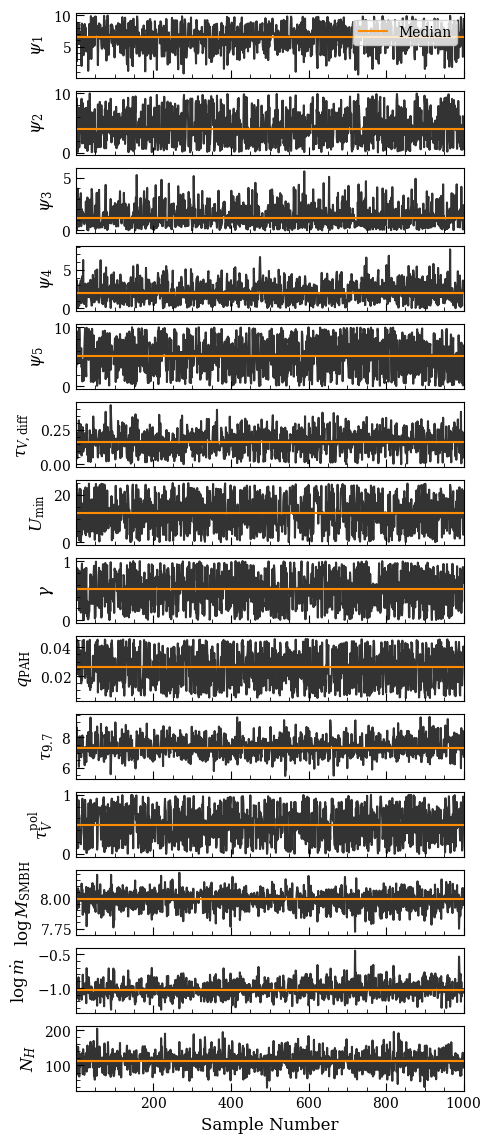

In [18]:
fig, axs = l.chain_plot(chain, color='k', alpha=0.8)

## Corner Plot

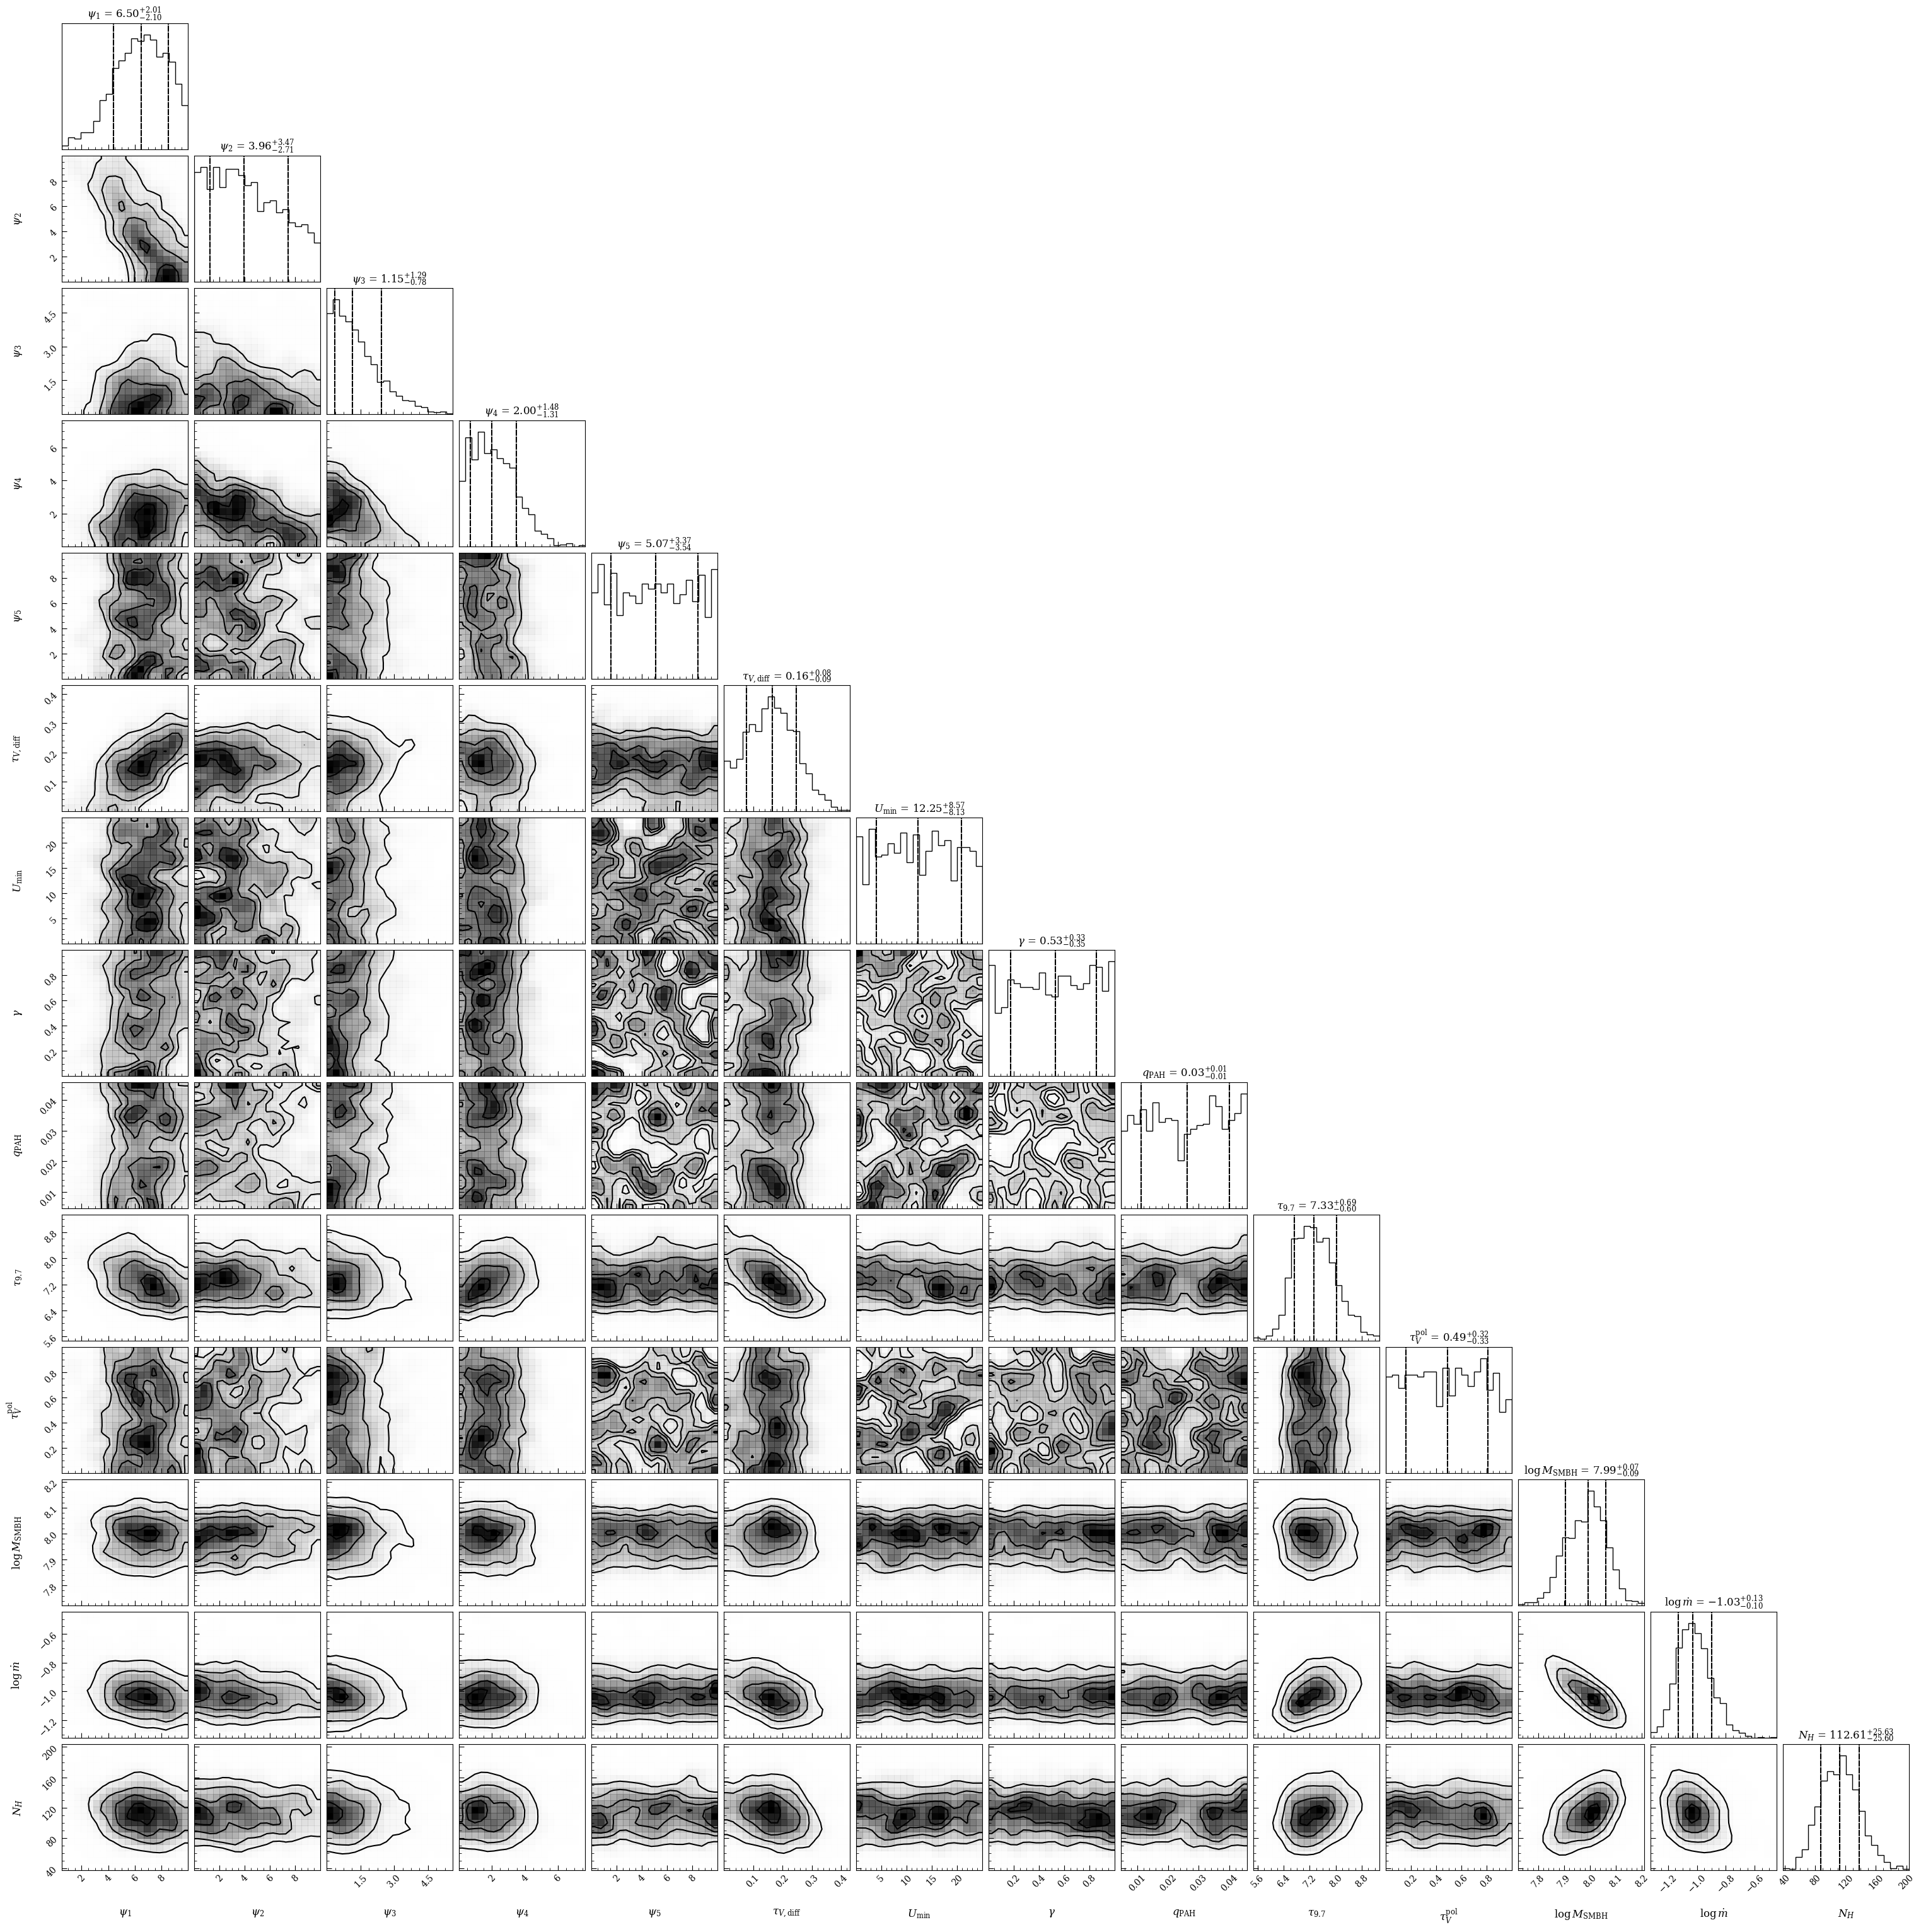

In [19]:
fig = l.corner_plot(chain, 
                    quantiles=(0.16, 0.50, 0.84),
                    smooth=1,
                    levels=None,
                    show_titles=True)

Clearly some of the dust model parameters are acting as nuisance parameters, contributing to our long autocorrelation times and low acceptance fraction. We've done a decent job constraining the QSOSED parameters, however.

## SED/SFH Plot
I still haven't properly added the X-ray models to the default plotting script, have I

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/xray/stellar.py:232: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/eqm5663/Research/code/plightning/lightning/xray/agn.py:612: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)


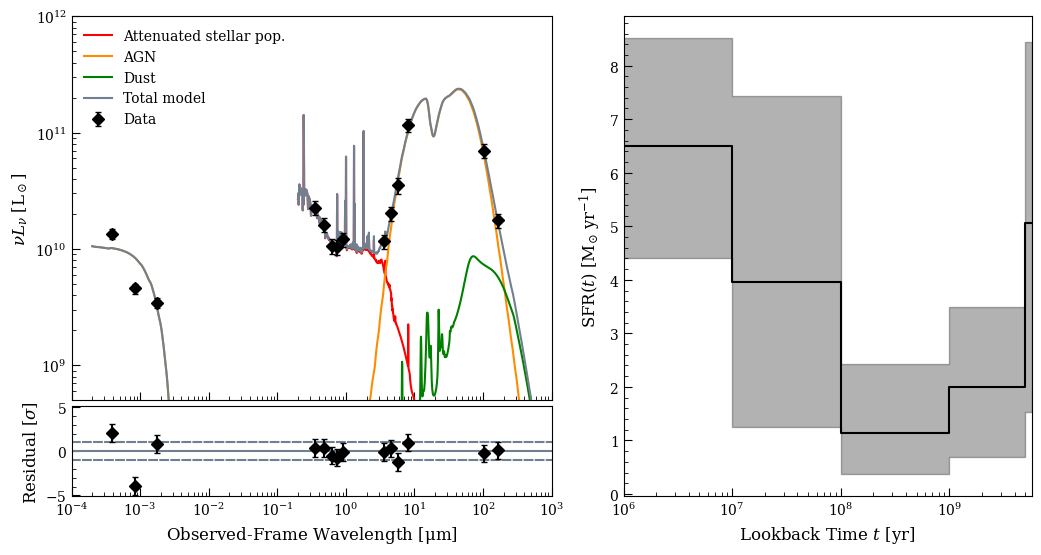

In [23]:
from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We can use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = l.sed_plot_bestfit(chain, logprob_chain,
                              plot_components=True,
                              ax=ax41,
                              xlim=(1e-4, 1e3),
                              legend_kwargs={'loc': 'upper left', 'frameon': False})

ax41.set_ylim(5e8, 1e12)

ax41.set_xticklabels([])
fig4, ax42 = l.sed_plot_delchi(chain, logprob_chain, xlim=(1e-4, 1e3), ax=ax42)
fig4, ax43 = l.sfh_plot(chain, ax=ax43)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/eqm5663/Research/code/plightning/lightning/xray/stellar.py:232: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.spe

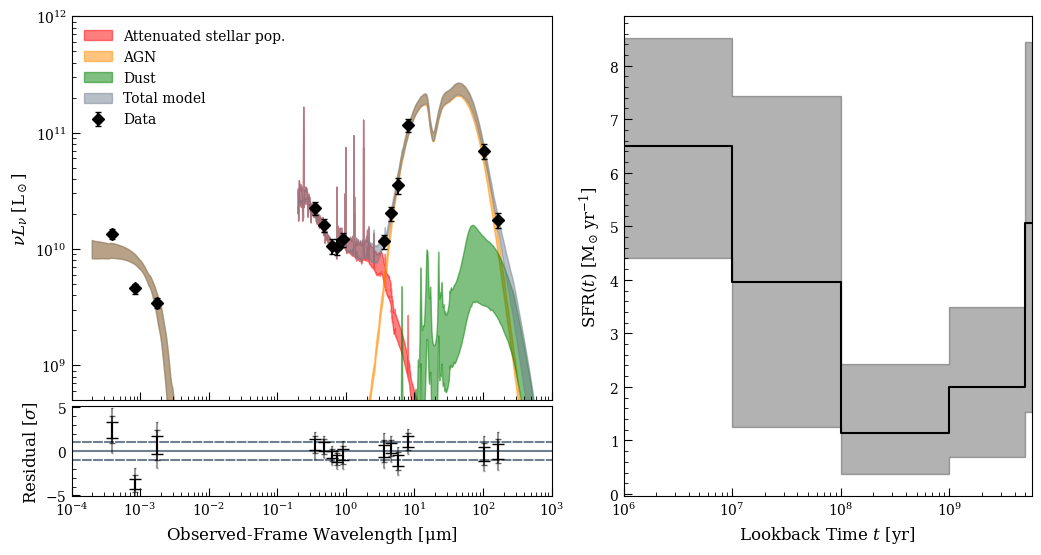

In [24]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian

fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = sed_plot_morebayesian(l, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax41,
                                   xlim=(1e-4, 1e3),
                                   legend_kwargs={'loc': 'upper left', 'frameon': False})

ax41.set_ylim(5e8, 1e12)

ax41.set_xticklabels([])
# This shows the median and selected percentiles of the residuals, but I don't love the way it looks. One could also
# just calculate delchi across the chain and plot randomly selected realizations.
fig4, ax42 = sed_plot_delchi_morebayesian(l, chain, logprob_chain, xlim=(1e-4, 1e3), ax=ax42)
fig4, ax43 = l.sfh_plot(chain, ax=ax43)

The X-ray fit looks poor, but that's mostly because I set the uncertainties too small to match the S/N to the UV-IR data.

## Redo the entire thing, fitting the X-ray fluxes

In [3]:
filter_labels = ['XRAY_2.0_7.0_keV', 'XRAY_1.2_2.0_keV', 'XRAY_0.5_1.2_keV',
                     'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                     'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                     'PACS_green', 'PACS_red']

redshift = 1.0
lum_dist = None

# arf = Table.read('../photometry/cdfn_near_aimpoint.arf')

# Fake an arf because the flux mode doesn't know how
# to handle the case 
arf = {'ENERG_LO': np.linspace(0.1, 10, 101)[1:],
       'ENERG_HI': np.linspace(0.1, 10, 101)[:-1],
       'SPECRESP': np.ones(100)}

l2 = Lightning(filter_labels,
             redshift=redshift,
             #lum_dist=lum_dist,
             flux_obs=None,
             flux_obs_unc=None,
             wave_grid=(1e-1, 1e3, 1200),
             SFH_type='Piecewise-Constant',
             atten_type='Calzetti',
             stellar_type='PEGASE',
             dust_emission=True,
             agn_emission=True,
             xray_stellar_emission='Stellar-Plaw',
             xray_agn_emission='QSOSED',
             xray_absorption='tbabs',
             galactic_NH=0.9, # times 10^20 cm-2
             xray_wave_grid=(1e-4, 1e-1, 200),
             xray_arf=None,
             xray_exposure=None,
             xray_mode='flux',
             print_setup_time=True,
             model_unc=0.10
             )

0.006 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.530 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.104 s elapsed in dust emission model setup
0.012 s elapsed in agn emission model setup
0.030 s elapsed in X-ray model setup
0.682 s elapsed total


In [4]:
# Recent SFH, relatively unobscured,
# assuming all the X-ray absorption is Galactic.
params = np.array([5,5,1,1,1,
                   0.02,
                   0.1,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7, 0.0,
                   1.8,
                   8, -1.0,
                   100.0])

Lmod, _ = l2.get_model_lnu(params)
Lmod_xray, Lmod_xray_abscorr = l2.get_xray_model_lnu(params)
# counts_mod = l.get_xray_model_counts(params)

# By (weird) construction, the elements of Lmod corresponding to the X-ray filters
# in Lmod are NaN, and the elements of Lmod_xray corresponding to the UV-IR filters
# are NaN.
xray_mask = np.isnan(Lmod)
#Lmod[xray_mask] = Lmod_xray[xray_mask]

snr = 10.0

rng = np.random.default_rng()

Lmod[xray_mask] = Lmod_xray[xray_mask]

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
# Note that the input units for the X-ray fluxes are also mJy; this is kind of weird since
# X-ray fluxes are typically not presented as monochromatic given the width of the bandpasses
# involved.
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
DL = cosmo.luminosity_distance(redshift)

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# The current setup for X-ray counts is to stick them into the flux array. You can
# imagine that this would be more intuitive if you were reading the data from a file
# rather than constructing it from a simulation
# counts_sim = rng.poisson(lam=counts_mod[xray_mask])
# fsim[xray_mask] = counts_sim
#fsim_unc[xray_mask] = 1 + np.sqrt(0.75 + counts_sim)
# fsim_unc[xray_mask] = counts_sim / snr

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l2.flux_obs = fsim
l2.flux_unc = fsim_unc

t = Table()
t['filter'] = l2.filter_labels
# t['flux_obs'] = l.flux_obs
# t['flux_unc'] = l.flux_unc
t['Lnu_obs'] = l2.Lnu_obs
t['Lnu_unc'] = l2.Lnu_unc
# t['xray_counts'] = l.xray_counts
# t['xray_counts_unc'] = l.xray_counts_unc

#ascii.write(t, format='fixed_width_two_line')
#print(counts_sim[xray_mask])
t.show_in_notebook()

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [5]:
# p = np.array([5,5,1,1,1,
#               0.1,
#               2, 1, 3e5, 0.1, 0.01,
#               11, 0.5, 7,
#               1.8,
#               8, -1.0,
#               100.0])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      True,
                      False,
                      True, False, True, False, False,
                      True, True, False, False,
                      True,
                      False, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          ConstantPrior([0.02]), # Z
          UniformPrior([0, 3]), # tauV
          ConstantPrior([2.0]), # alpha
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          ConstantPrior([11.0]), # log L_AGN -- constant here because we're using the qsosed model.
          ConstantPrior([0.5]), # cos i
          UniformPrior([3,11]), # tau 9.7
          UniformPrior([0,1]), # polar dust tauV
          ConstantPrior([1.8]), # stellar pop. pho. index
          UniformPrior([6,9]), # SMBH mass
          UniformPrior([-1.5, 0.0]), # log Eddington ratio
          UniformPrior([1, 500]) # NH
          ]

Nwalkers = 64
Nsteps = 20000

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=1)
print(p0.shape)

(64, 20)


In [6]:
mcmc = l2.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=Nsteps, priors=priors, const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|█████████████████████████████████████████████████████████| 20000/20000 [08:13<00:00, 40.55it/s]


In [7]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.184


In [8]:
chain, logprob_chain, tau_ac = l2.get_mcmc_chains(mcmc, discard=2000, thin=500, flat=True,
                                                 const_vals=p0[0,const_dim],
                                                 const_dim=const_dim)

         The autocorrelation estimate may be unreliable.


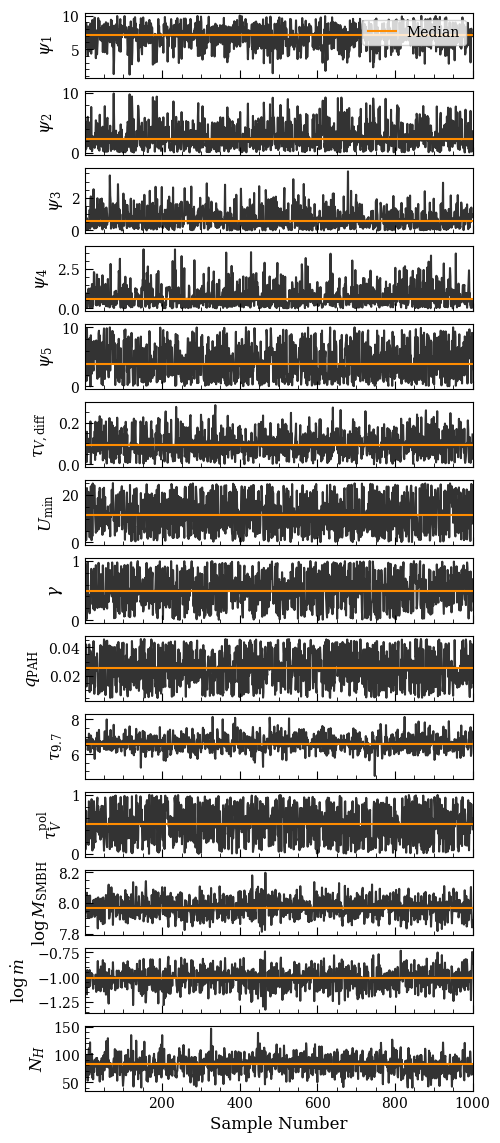

In [9]:
fig, axs = l2.chain_plot(chain, color='k', alpha=0.8)

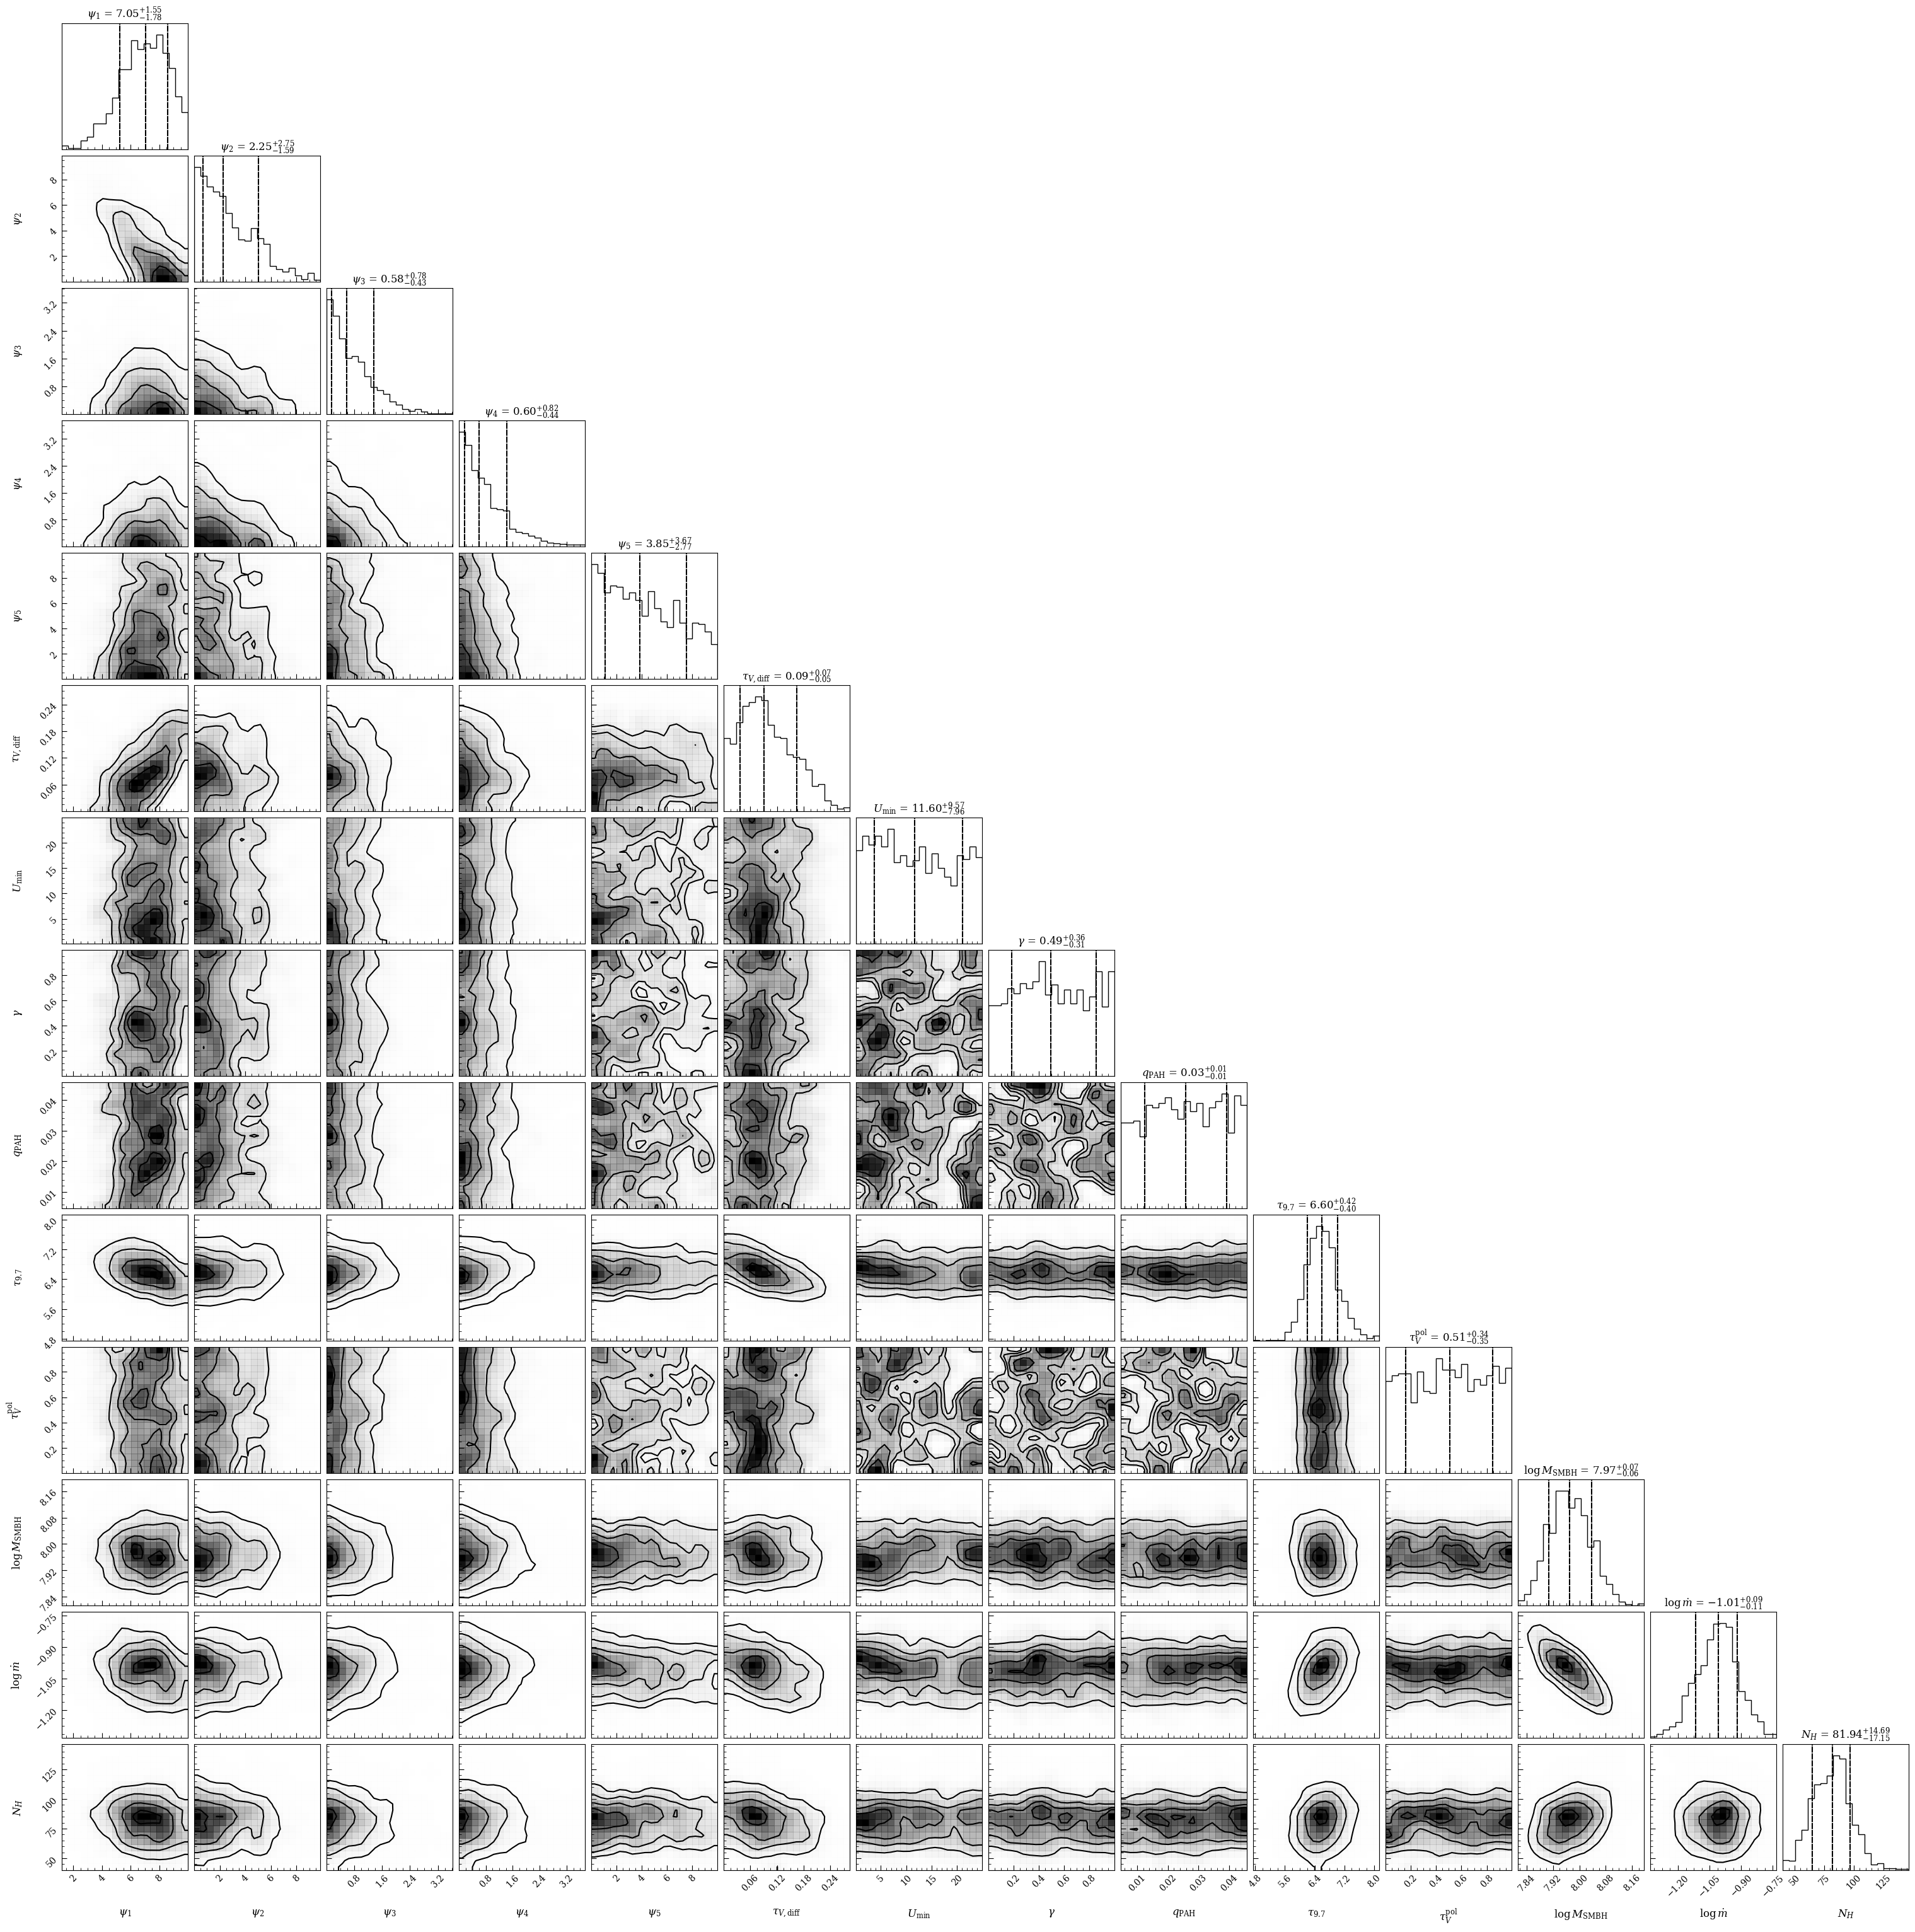

In [10]:
fig = l2.corner_plot(chain, 
                     quantiles=(0.16, 0.50, 0.84),
                     smooth=1,
                     levels=None,
                     show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:434: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanm

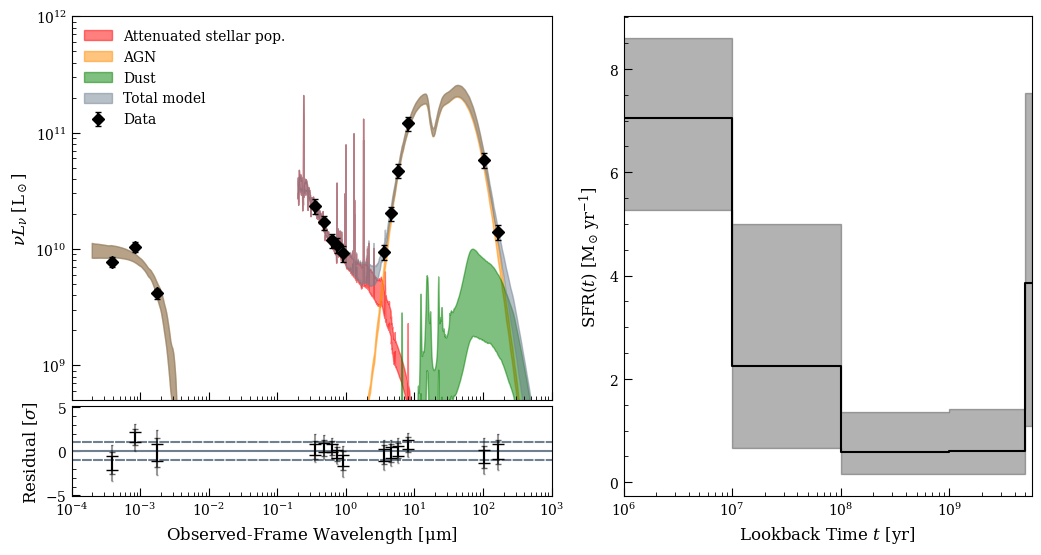

In [11]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian

fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = sed_plot_morebayesian(l2, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax41,
                                   xlim=(1e-4, 1e3),
                                   legend_kwargs={'loc': 'upper left', 'frameon': False})

ax41.set_ylim(5e8, 1e12)

ax41.set_xticklabels([])
# This shows the median and selected percentiles of the residuals, but I don't love the way it looks. One could also
# just calculate delchi across the chain and plot randomly selected realizations.
fig4, ax42 = sed_plot_delchi_morebayesian(l2, chain, logprob_chain, xlim=(1e-4, 1e3), ax=ax42)
fig4, ax43 = l2.sfh_plot(chain, ax=ax43)